In [1]:
from lib.utils import load_raw_by_path
from torch import nn
from torch.nn.functional import batch_norm,relu
from torch import nn
import numpy as np
from torch.nn.functional import softmax
import torch
import sqlite3
from sqlite3 import Error
import os
import pandas as pd
from tqdm import tqdm
device = 'cuda'
EEG_1 = [1,8,14,15,16]
EEG_2 = [3,4,5,6,7,9,10,11,12,13,17]

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lib.models import ResNet
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms
class CNNLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = ResNet().cuda()
        self.lstm = nn.LSTM(3,64)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d):
        x_2d = x_2d.view(-1,3,1,5000)
        x = torch.Tensor().cuda()
        for t in range(x_2d.size(1)):
            x_i = self.resnet(x_2d[:,t,:,:])
            x_i = x_i.view(-1,3)
            out,_ = self.lstm(x_i)

            # x = torch.cat([x,x_i.unsqueeze(0)])
        x = self.fc1(out)        
        # return x.view(-1,3,3)
        return x

In [4]:
model = CNNLSTM().to(device)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [5]:
import torch
from tqdm import tqdm
from lib.utils import load_raw_list
import os
from sklearn.model_selection import train_test_split
normalize = True
X,y = load_raw_list([20])

if(normalize):
    # center, stretch
    X = (X - X.mean(axis=1,keepdim=True))/X.std(axis=1,keepdim=True)
    # drop row if any element is inf
    not_inf_idx = torch.where(~X.isinf().any(axis=1))[0]
    X,y = X[not_inf_idx], y[not_inf_idx]

X = torch.cat([X[:-2],X[1:-1],X[2:]],axis=1)
y = y[2:]

In [6]:
from torch.utils.data import DataLoader,TensorDataset
devloader = DataLoader(TensorDataset(X,y),batch_size=64)

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


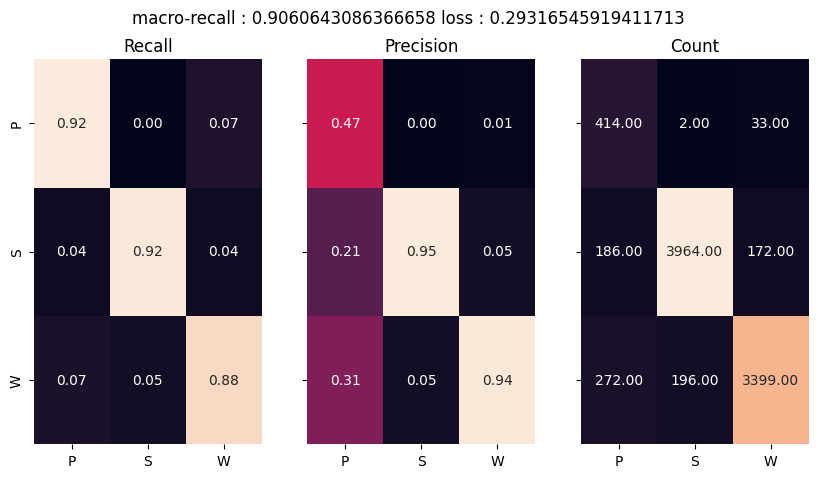

In [7]:
criterion = nn.CrossEntropyLoss()

y_true = torch.Tensor()
y_pred = torch.Tensor().cuda()
model.eval()
loss_dev_total = 0
for (X_dv,y_dv) in devloader:
    X_dv,y_dv = X_dv.to(device),y_dv.to(device)
    logits = model(X_dv)
    loss = criterion(logits,y_dv)
    loss_dev_total += loss.item()

    y_true = torch.cat([y_true,y_dv.cpu().argmax(axis=1)])
    y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1)])

cms(y_true=y_true,y_pred=y_pred.cpu(),loss=loss_dev_total/len(devloader))

In [11]:
pred_expert = np.array(y_pred.detach().cpu()).copy()
print("Experting")
for j in range(len(pred_expert)-2):
    if((pred_expert[j:j+2]==np.array([2,0])).all()):
        pred_expert[j+1] = 2
for j in range(len(pred_expert)-2):
    if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
        pred_expert[j+1] = pred_expert[j]
df = pd.DataFrame(pred_expert)
df[df[0] == 0] = 'P'
df[df[0] == 1] = 'S'
df[df[0] == 2] = 'W'
print(df[0].value_counts(normalize=True))
df.to_csv(f'pred.csv',index=False)
from lib.utils import get_bout_statistics_for_predictions
stats_pred = get_bout_statistics_for_predictions(df[0])

Experting
S    0.495254
W    0.449525
P    0.055221
Name: 0, dtype: float64


In [12]:
stats_true = get_bout_statistics_for_predictions(pd.read_csv(f'data/alpha_sleep/20.csv')['label'])

In [15]:
((stats_pred-stats_true)/stats_true)*100

,P,S,W
total,6.236080,-1.018047,0.361851
average,-22.852370,4.372059,6.767926
counts,37.704918,-5.164319,-6.000000
